In [1]:
from collections import defaultdict, OrderedDict
from functools import reduce
from itertools import chain, cycle, islice

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import smartsheet

from portfolio import (FTECashFlow, CashFlow, combine_flows, debug_row, discount,
                       PortfolioFTEParser, PortfolioSheetRow, debug_row)
from utils import colorscale, get_smartsheet_cell, currency_fmt_to_cols, SmartsheetRow, scan_rows_for_start_stop

# Portfolio Cash Flow Analysis

In [2]:
SHOW_DISCOUNTED = True
SHOW_UNDISCOUNTED = False

# Define a quartely time schema
years_in_model = 3
periods_in_year = 4

# TODO: rename to "periods_1_12"
quarters = list(range(1, years_in_model * periods_in_year + 1))  # list bc we don't want this to be a generator

# TODO: rename to "periods_0_11"
quarters_index = list(range(years_in_model * periods_in_year))
quarter_labels = ['Q' + str(q) for q in quarters]

# smartsheet
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

# COST_BASELINE = get_smartsheet_cell(21, 3, sheet, 'value') / periods_in_year  # ($M/year)
COST_VARIABLE = get_smartsheet_cell(21, 3, sheet, 'value') / periods_in_year  # ($/DGY)
COST_PER_FTE  = get_smartsheet_cell(12, 3, sheet, 'value') / periods_in_year  # ($M/yr)

In [3]:
SCENARIO_ROW_START, SCENARIO_ROW_END = scan_rows_for_start_stop(sheet, 'Recommended Scenario', as_index=True)

In [4]:
def sheet_row_to_cf(row):
    if isinstance(row, PortfolioSheetRow):
        return CashFlow(
            delay_qtrs = row.delay_qtrs,
            digital_gallons = row.digital_gallons,
            discount_rate = row.discount_rate,
            max_amt = row.max_amt,
            scale_up_qtrs = row.scale_up_qtrs,
            function = row.function,
            name = row.name,
            is_cost = row.is_cost,
            start_amt = row.start_value,
            vc_per_dg = COST_VARIABLE
        )
    else:  # PortfolioFTEParser
        return FTECashFlow(
            discount_rate = row.discount_rate,
            fte_per_period = row.fte_per_period,
            fte_period_cost = COST_PER_FTE,
            fte_y1 = row.fte_y1,
            fte_y2 = row.fte_y2,
            fte_y3 = row.fte_y3,
            name = row.name
        )


def get_parser_for_row(sheet_row):
    """Not all rows are the same. This function will choose the correct parser,
       and show there is not a parser if it is a row that should be skipped"""
    cells = sheet_row.to_dict()['cells']
    include = cells[PortfolioSheetRow.CELL_08.index].get('value', None)
    include = True if include == "Yes" else False
    project_code = cells[PortfolioSheetRow.CELL_09.index].get('value', None)
    function = cells[PortfolioSheetRow.CELL_14.index].get('value', None)
    if not include or project_code is None or function is None:
        return None
    elif function == 'Multi-Step (Yr)':
        return PortfolioFTEParser
    else:
        return PortfolioSheetRow
    
# iterate through smartsheet and build project map, then sort it
project_map = defaultdict(list)
for sheet_row in sheet.rows[SCENARIO_ROW_START:SCENARIO_ROW_END]:
    Parser = get_parser_for_row(sheet_row)
    if Parser is None:
        continue

    row = Parser(sheet_row.to_dict())
    project_map[row.project_code].append(sheet_row_to_cf(row))

project_map = OrderedDict(sorted(project_map.items()))  # sort ordered dictionary by keys

In [5]:
# Build Cash Flow DataFrame from project_map
rows = []
for project_id, cash_flows in project_map.items():
    for cash_flow in cash_flows:
        rows.append([project_id, True, cash_flow.name] + cash_flow.discounted_qtr)  # Discounted
        rows.append([project_id, False, cash_flow.name] + cash_flow.non_discounted_qtr)  # Undiscounted
        
cf_df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)

if SHOW_DISCOUNTED and not SHOW_UNDISCOUNTED:
    cf_df = cf_df[cf_df['discounted']]
elif SHOW_UNDISCOUNTED and not SHOW_DISCOUNTED:
    cf_df = cf_df[cf_df['discounted'] == False]
# else leave dataframe as is


summarized_df = cf_df.groupby(['project', 'discounted'])\
                  .sum(numeric_only=True)\
                  .sum(numeric_only=True, axis=1)\
                  .reset_index(name='NPV ($)')\
                  .sort_values(by=['project'])

# Create a dataframe with variable cost
rows = []
for project_id, flows in project_map.items():
    unit_multiplier = 10**6  # put in dollars
    dg_to_variable_cost = lambda v: v * unit_multiplier * COST_VARIABLE

    for cf in flows:
        d_dg_cost = list(map(dg_to_variable_cost, cf.discounted_dg_qtr))
        nd_dg_cost = list(map(dg_to_variable_cost, cf.non_discounted_dg_qtr))
        d_variable_cost = [0]  # No variable cost at Q0
        nd_variable_cost = [0]  # No variable cost at Q0
        # iterable is of form [(0, (0, 1)), (1, (1, 2)), (n, (n + 1))]
        for index, step in list(enumerate(zip(quarters_index, quarters)))[:-1]:
            # integraing using trapezoidal riemann sum
            d_variable_cost.append(np.trapz([d_dg_cost[index], d_dg_cost[index + 1]], step))
            nd_variable_cost.append(np.trapz([nd_dg_cost[index], nd_dg_cost[index + 1]], step))
    
        rows.append([project_id, True, cf.name] + d_variable_cost)
        rows.append([project_id, False, cf.name] + nd_variable_cost)
    
vc_df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
summarized_vc_df = vc_df.groupby(['project', 'discounted'])\
                      .sum(numeric_only=True)\
                      .sum(numeric_only=True, axis=1)\
                      .reset_index(name='Variable Cost ($)')\
                      .sort_values(by=['project'])

# Merge the two together
summarized = pd.merge(summarized_df, summarized_vc_df, how='inner', on=['project', 'discounted'])
summarized = summarized.apply(currency_fmt_to_cols(['NPV ($)', 'Variable Cost ($)']))

def prepare_npv_df(df, is_discounted):
    title = ('Discounted' if is_discounted else 'Undiscounted') + ' Cash Flow Summary'
    display(HTML(f'<h4>{title}</h4>'))
    df_sum = df[summarized_df['discounted'] == is_discounted].copy()
    df_sum.drop(['discounted'], axis=1, inplace=True)
    df_sum.loc["Total"] = df_sum.sum(numeric_only=True)
    df_sum.at['Total','project'] = '-'
    df_sum = df_sum.apply(currency_fmt_to_cols(['NPV ($)']))
    return df_sum

if SHOW_DISCOUNTED:
    display(prepare_npv_df(summarized_df, True))
    
if SHOW_UNDISCOUNTED:
    display(prepare_npv_df(summarized_df, False))

,project,NPV ($)
0,BP,3.1m
1,FS,8.91m
2,INT,-2.77m
3,PV,3.51m
Total,-,12.8m


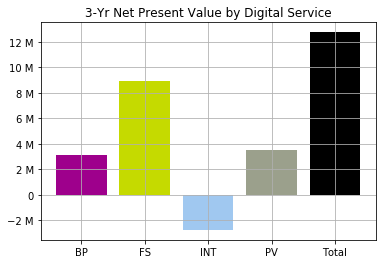

In [6]:
def gen_label(row):
    postfix = ''
    if SHOW_DISCOUNTED and SHOW_UNDISCOUNTED: # only apply postfix if both
        postfix = '_discounted' if row['discounted'] else ''

    return row['project'] + postfix
    
table = cf_df.groupby(['project', 'discounted'])\
          .sum(numeric_only=True)\
          .sum(numeric_only=True, axis=1)\
          .reset_index(name='NPV')\
          .sort_values(by=['project'])

if SHOW_UNDISCOUNTED:
    table.loc[table.shape[0]] = ['Total', False, table[table['discounted'] == False]['NPV'].sum()]
if SHOW_DISCOUNTED:
    table.loc[table.shape[0]] = ['Total', True, table[table['discounted']]['NPV'].sum()] 
table['label'] = table.apply(gen_label, axis=1)

colors = ["#9e008c", "#C5DA00", "#A0C8F0", "#9BA08C", 'black']

fig = plt.figure()
fig.patch.set_facecolor('#ffffff')
ax = fig.add_subplot(1, 1, 1)
if SHOW_DISCOUNTED and SHOW_UNDISCOUNTED:
    colors_cycled = list(islice(
        cycle(colors),     # generator of infinitely repeated colors
        0,                 # start at the beginning
        len(project_map) + 1),
    )
    darkened_colors = map(lambda color: colorscale(color, .5), colors_cycled)
    bar_colors = list(chain.from_iterable(zip(colors_cycled, darkened_colors)))
    ax.tick_params(axis='x', labelrotation=90)
else:
    bar_colors = colors

ax.bar(table['label'], table['NPV'], color=bar_colors)
ax.set_title('3-Yr Net Present Value by Digital Service')
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.grid(True)

In [7]:
def display_dataframe(df, title):
    display(HTML(f'<h3>{title}</h3>'))
    df.loc["Total"] = df.sum(numeric_only=True)
    df = df.apply(currency_fmt_to_cols(quarter_labels))
    cleaned = df.drop(['project', 'discounted'], axis=1)
    display(cleaned)

for project_id in cf_df['project'].unique():
    display(HTML(f'<div><h1>{project_id}</h1><hr /></div>'))
    ndf = cf_df[cf_df['project'] == project_id].set_index('name')
    if SHOW_DISCOUNTED:
        display_dataframe(ndf[ndf['discounted']].copy(), "Discounted Cash Flows")
    if SHOW_UNDISCOUNTED:
        display_dataframe(ndf[ndf['discounted'] == False].copy(), "Undiscounted Cash Flows")

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Batch Internal Headcount,-198k,-193k,-188k,-184k,-224k,-218k,-213k,-208k,-264k,-257k,-251k,-245k
Batch External Investment,-100k,-104k,-107k,-110k,-114k,-117k,-120k,-124k,-127k,-130k,-133k,-136k
Revenue Defense - Showme,23.4k,23.2k,23k,22.8k,22.6k,22.4k,22.2k,22k,21.8k,21.5k,21.3k,21.2k
East Kansas - Defense,0,0,14.7k,14.6k,14.5k,14.3k,14.2k,14.1k,13.9k,13.8k,13.7k,13.5k
United Ethanol Whitespace Win,234k,232k,230k,228k,226k,224k,222k,220k,218k,215k,213k,212k
Guardian - Hankinson Defense,0,0,0,0,0,21.7k,21.4k,21k,20.7k,20.4k,20.1k,19.8k
Alcorn - Defense / Contract Extension,0,0,0,47.7k,47k,46.3k,45.6k,44.9k,44.2k,43.5k,42.8k,42.2k
Valero - Net new,0,0,0,0,0,0,0,0,0,0,0,146k
Madeira - Fleet Trials,0,0,0,0,0,0,0,0,0,21.7k,21.4k,21.1k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Internal Headcount,-148k,-145k,-141k,-138k,-179k,-175k,-170k,-166k,-223k,-218k,-212k,-207k
Pipeline FS Product Credits,-45k,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
Pipeline FS - Stockton,0,0,0,0,21.2k,20.7k,20.2k,19.7k,19.2k,18.8k,18.3k,17.9k
Pipeline FS - Magic Valley,0,0,22.9k,22.6k,22.3k,22k,21.8k,21.5k,21.2k,21k,20.7k,20.4k
Pipeline FS - Aurora,0,0,22.9k,22.6k,22.3k,22k,21.8k,21.5k,21.2k,21k,20.7k,20.4k
Projected Offensive Wins,0,92.6k,151k,240k,371k,545k,754k,974k,1.17m,1.33m,1.44m,1.5m
Projected Defensive Wins,0,20.8k,33.9k,54.1k,83.4k,123k,170k,219k,264k,299k,323k,338k
Total,-193k,-31.3k,89.4k,202k,341k,558k,817k,1.09m,1.27m,1.47m,1.61m,1.69m


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-188k,-183k,-179k,-174k,-210k,-205k,-200k,-195k,-252k,-245k,-239k,-234k
Internal Headcount,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
Internal Headcount,-24.7k,-24.1k,-23.5k,-23k,-22.4k,-21.8k,-21.3k,-20.8k,-20.3k,-19.8k,-19.3k,-18.8k
Total,-213k,-207k,-202k,-197k,-233k,-227k,-222k,-216k,-272k,-265k,-259k,-252k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
PV Internal Headcount,-124k,-121k,-118k,-115k,-157k,-153k,-149k,-146k,-203k,-198k,-193k,-188k
Benefits - Contracted GPRE,0,0,227k,224k,220k,217k,214k,210k,207k,204k,201k,198k
Benefits - Potential GPRE,0,0,0,0,0,70.3k,135k,247k,415k,622k,815k,951k
Total,-124k,-121k,110k,109k,63.5k,134k,199k,312k,420k,628k,823k,961k


In [8]:
class Project():
    """Add cash flows to a project"""
    def __init__(self, name, cash_flows=None):
        self.name = name
        self.cash_flows = cash_flows
        # Generate Graph portion
        self.graph_out = widgets.Output()
        self.update_graphs()
        # Generate Table portion
        self.table_out = widgets.Output()
        self.update_table()
        self.app = widgets.VBox(children=[self.graph_out, self.table_out], layout=widgets.Layout(overflow="hidden"))
        display(self.app)
    
    def to_df(self):
        df = pd.DataFrame(map(lambda cf: cf.to_json(), self.cash_flows)).drop(['flow_id'], axis=1)
        return df.set_index('name')
            
    def update_table(self):
        self.table_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return
        
        table = self.to_df()
        with self.table_out:
            display(table)
        
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]
        
        def get_max(flows):
            values = reduce(
                list.__add__,
                [list(map(
                    lambda v: abs(v),
                    flow.non_discounted_qtr + flow.discounted_qtr
                )) for flow in flows])
            maximum = max(values)
            maximum += maximum * .2  # pad value
            return -1 * maximum, maximum
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 4
            num_cash_flows = len(self.cash_flows)
            rows = 1 if num_cash_flows == 4 else num_cash_flows // cols + 1
            figsize = (12, rows * 3)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            fig.patch.set_facecolor('#ffffff')
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_max(self.cash_flows)
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.yaxis.set_major_formatter(ticker.EngFormatter())
                ax.xaxis.set_ticks(range(1, 13))
                ax.axhline(y=0, color='black', linestyle='--')
                ax.plot(quarters_index, cf.discounted_qtr, color='r', label='discounted')
                ax.plot(quarters_index, cf.non_discounted_qtr, label='non-discounted')
                ax.legend()
                
            plt.show(fig)

In [9]:
# Build UI from project_map
projects = []
for project_id, cash_flows in project_map.items():
    display(HTML(f'<div><h1>{project_id} - EBITDA</h1><br /><hr /></div>'))
    projects.append(Project(project_id, cash_flows))
    
projects.sort(key=lambda x: x.name)

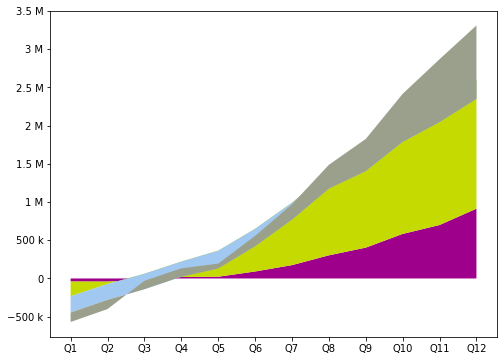

In [10]:
def plot_stack_ebitda_contribution(is_discounted):
    flows = [quarter_labels]  # first argument are x-labels in stackplots
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('#ffffff')
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    cf_attribute = 'discounted_qtr' if is_discounted else 'non_discounted_qtr'
    for project in projects:
        aggregated_qtr = combine_flows(project.cash_flows, cf_attribute)
        flows.append(aggregated_qtr)
        
    plt.stackplot(
        *flows,
        labels=list(map(lambda p: p.name, projects)),
        colors=colors
    )
    plt.show()

plot_stack_ebitda_contribution(is_discounted=True)

In [11]:
graph_out = widgets.Output()

def get_x_ticks(index, bar_width, step=1):
    return [x - (bar_width * len(projects)) + (bar_width * index) for x in range(12)]

def plot_projects_summary(is_discounted):
    cf_attribute = 'discounted_qtr' if is_discounted else 'non_discounted_qtr'
    projects_values = map(lambda p: combine_flows(p.cash_flows, cf_attribute), projects)
    projects_net = [sum(values) for values in zip(*projects_values)]

    figsize = (16, 8)
    fig, ax = plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    fig.patch.set_facecolor('#ffffff')
    plt.xticks(range(0, 12))
    bar_room = .75 # 75% of space will have a bar plotted on it
    bar_width = bar_room * 1 / (len(projects) + 1)  # + 1 in denominator to account for 'net'
    legend_parents = []
    for i, project in enumerate(projects):
        xseries = get_x_ticks(i, bar_width)
        plot = plt.bar(
            xseries,
            combine_flows(project.cash_flows, cf_attribute),
            width=bar_width,
            color=colors[i]
        )
        legend_parents.append(plot)

    legend_parents = [p[0] for p in legend_parents]
    net_xseries = get_x_ticks(len(projects), bar_width)
    net_plot = plt.bar(quarter_labels, projects_net, color='black', width=bar_width)

    legend_parents.append(net_plot[0])
    plt.legend((*legend_parents,), (*map(lambda p: p.name, projects), 'net'), loc='upper left')
    plt.show()
    
def plot_digital_gallons(is_discounted):
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('#ffffff')
    flows = [quarter_labels]  # first argument are x-labels in stackplots
    cf_attribute = 'discounted_dg_qtr' if is_discounted else 'non_discounted_dg_qtr'
    for project in projects:
        aggregated_dg_qtr = combine_flows(project.cash_flows, cf_attribute)
        flows.append(list(map(lambda x: x * 10**6, aggregated_dg_qtr)))
        
    plt.stackplot(
        *flows,
        labels=list(map(lambda p: p.name, projects)),
        colors=colors
    )
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.legend(loc='upper left')
    plt.title('Digital Gallon Contribution')
    plt.ylabel('Digital Gallons')
    plt.show()


def graph_projects_cash_flow(_):
    graph_out.clear_output(wait=True)
    
    with graph_out:
        if SHOW_DISCOUNTED:
            display(HTML('<h3>Discounted Digital Gallons</h3>'))
            plot_digital_gallons(is_discounted=True)
            
        if SHOW_UNDISCOUNTED:
            display(HTML('<h3>Undiscounted Digital Gallons</h3>'))
            plot_digital_gallons(is_discounted=False)
        
        if SHOW_DISCOUNTED:
            display(HTML('<h3>Discounted EBITDA Contribution</h3>'))
            plot_projects_summary(is_discounted=True)
        
        if SHOW_UNDISCOUNTED:
            display(HTML('<h3>Undiscounted EBITDA Contribution</h3>'))
            plot_projects_summary(is_discounted=False)

with graph_out:
    graph_projects_cash_flow(None)

# button = widgets.Button(description='Refresh Chart')
# button.on_click(graph_projects_cash_flow)

chart = widgets.VBox(children=[graph_out])
chart

In [12]:
cf_df.sort_values(by=['discounted', 'project'], inplace=True)

In [13]:
import string
alphabet = string.ascii_uppercase
excel_columns_names = list(alphabet)
for letter1 in alphabet:
    for letter2 in alphabet:
        excel_columns_names.append(f'{letter1}{letter2}')

In [14]:
# This entire cell contains all of the code needed
# to build the excel sheet to be downloaded

def record_project(project, sheet, start_row, start_column=0):
    df = project.to_df()
    df = df.fillna(0)
    bold = workbook.add_format({'bold': True})
    row_num = start_row
    # Write the project name
    sheet.write(row_num, start_column, project.name)
    row_num += 1
    # write index then columns
    sheet.write(row_num, start_column, 'index', bold)
    for col_index, col in enumerate(df, 1):  # start at 1 since index was written
        sheet.write(row_num, start_column + col_index, col, bold)
        
    for index, row in df.iterrows():
        row_num += 1
        sheet.write(row_num, start_column, index)
        for col_index, cell_value in enumerate(row, 1):
            sheet.write(row_num, start_column + col_index, cell_value)

writer = pd.ExcelWriter('./demo.xlsx', engine='xlsxwriter')
cf_df.to_excel(writer, sheet_name='output', index=False)

# calculate which cells hold the quarter values
num_quarters = len(quarters)
start_row = 2
end_row = start_row + len(cf_df) - 1
QUARTER_START_COLUMN = 3  # After 'project', 'discouted', and 'name'
start_quarter_columns = excel_columns_names[QUARTER_START_COLUMN]
end_quarter_columns = excel_columns_names[QUARTER_START_COLUMN + num_quarters]
quarter_cells = f'{start_quarter_columns}{start_row}:{end_quarter_columns}{end_row}'

# grab objects from pandas object
workbook  = writer.book
output_worksheet = writer.sheets['output']
projects_worksheet = workbook.add_worksheet('projects')

start_row = 0
for project in projects:
    record_project(project, projects_worksheet, start_row)
    start_row += len(project.cash_flows) + 3  # 3 for project name, header row, and a space

# create and apply formatting
float_format = workbook.add_format({'num_format': '##0.0000'})
## output sheet
output_worksheet.set_column(quarter_cells, None, float_format)
output_worksheet.set_column('C:C', 30)
output_worksheet.conditional_format(quarter_cells, {'type': '3_color_scale'})
## project sheet
projects_worksheet.set_column('A:A', 30)
projects_worksheet.set_column('B:H', 15)

writer.save()

In [15]:
# %%html
# <style>
# .dwnld {
#     border: 1px solid black;
#     border-radius: 4px;
#     padding: 5px;
#     text-decoration: none !important;
# }
# </style>
# <a class="dwnld" href="./voila/static/demo.xlsx" download="demo.xlsx">Download Excel Sheet</a>

In [16]:
# Play instances
# cf = CashFlow(
#     delay_qtrs=4, digital_gallons=100, discount_rate=.1, function='sigmoid',
#     is_cost=False, start_amt=1, max_amt=5, scale_up_qtrs=4, tot_qtrs=12, name='test'
# )
# cf.quick_view(discounted=False)